# Creating dataset to analyze bike sharing demand in Washington D.C.

In [1]:
import pandas as pd
import glob
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sb
import matplotlib.pyplot as plt


In [2]:
# display all rows and columns in the dataframes
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


## Bike sharing stations and locations dataset

In [3]:
# read in dataset that contains location information on bike stations
bike_station_df = pd.read_csv('datasets/bike-stations/Capital_Bike_Share_Locations.csv')
bike_station_df.head()


,OBJECTID,ID,ADDRESS,TERMINAL_NUMBER,LATITUDE,LONGITUDE,INSTALLED,LOCKED,INSTALL_DATE,REMOVAL_DATE,TEMPORARY_INSTALL,NUMBER_OF_BIKES,NUMBER_OF_EMPTY_DOCKS,X,Y,SE_ANNO_CAD_DATA,OWNER
0,292811730,479,Columbus Ave & Gramercy Blvd,32069,39.123330,-77.164860,YES,NO,NaN,NaN,NO,8,3,385744.186615,161710.152819,NaN,NaN
1,292811731,480,Reston Pkwy & Spectrum Dr,32225,38.964208,-77.354280,YES,NO,NaN,NaN,NO,5,10,369296.122237,144092.525801,NaN,NaN
2,292811732,481,Key West Ave & Great Seneca Hwy,32070,39.105642,-77.203860,YES,NO,NaN,NaN,NO,3,7,382367.389360,159753.369415,NaN,NaN
3,292811733,482,Virginia Ave & 25th St NW,31297,38.899500,-77.054155,YES,NO,NaN,NaN,NO,12,7,395302.353355,136851.190868,NaN,DC
4,292811734,483,15th & M St NW,31298,38.905424,-77.034674,YES,NO,NaN,NaN,NO,10,9,396992.472005,137507.980428,NaN,DC


In [4]:
# drop all irrelevant columns
bike_station_df_drop = bike_station_df.drop(['ADDRESS', 'TERMINAL_NUMBER', 'OBJECTID', 'ID', 'INSTALLED', 'LOCKED', 'INSTALL_DATE',
                                             'REMOVAL_DATE', 'TEMPORARY_INSTALL', 'NUMBER_OF_BIKES',
                                             'NUMBER_OF_EMPTY_DOCKS', 'X', 'Y', 'SE_ANNO_CAD_DATA',
                                             'OWNER'], axis=1)

bike_station_df_drop.head()


,LATITUDE,LONGITUDE
0,39.123330,-77.164860
1,38.964208,-77.354280
2,39.105642,-77.203860
3,38.899500,-77.054155
4,38.905424,-77.034674


In [5]:
print('Number of stations in DC metro area:', bike_station_df_drop.shape[0])

Number of stations in DC metro area: 578


Predicting the future demand at every single station may lead to inaccurate results because some stations may have little data. I think it makes more sense to focus on entire areas and predict shared bike demand for a cluster of bike sharing stations. The DC metro area includes more jurisdictions than just Washington, D.C., and therefore information on Washington neighborhoods are insufficient to cover the broader Capital Bikeshare system. Therefore, I will use the unsupervised learning algorithm KMeans to cluster bike stations by their location.

We're not using Washington, D.C., neighborhoods to cluster the bike stations because the stations are also located outside of the city boundaries. The capital bikeshare dataset covers 7 jurisdictions in the metro DC area: Washington, DC.; Arlington, VA; Alexandria, VA; Montgomery, MD; Prince George's County, MD; Fairfax County, VA; and the City of Falls Church, VA.(https://www.capitalbikeshare.com/how-it-works)

Also, the weather data includes stations in these areas, so the average daily weather has been included for all locations. (See station list of weather dataset)

According to (https://secure.capitalbikeshare.com/map/), the map matches the clustering plot below.


In [7]:
# The following code was adapted from https://github.com/julianikulski/identifying-customer-segments/blob/master/Identify_Customer_Segments.ipynb
# Calculating centers for up to 40 clusters
all_centroids = []
clust_count = 40
for i in range(1, clust_count):
    # run kmeans algorithm on i clusters
    kmeans_i = KMeans(n_clusters=i, random_state=42)
    # calculate the average within-cluster distances
    print(kmeans_i)
    model_i = kmeans_i.fit(bike_station_df_drop).score(bike_station_df_drop)
    all_centroids.append(model_i)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k

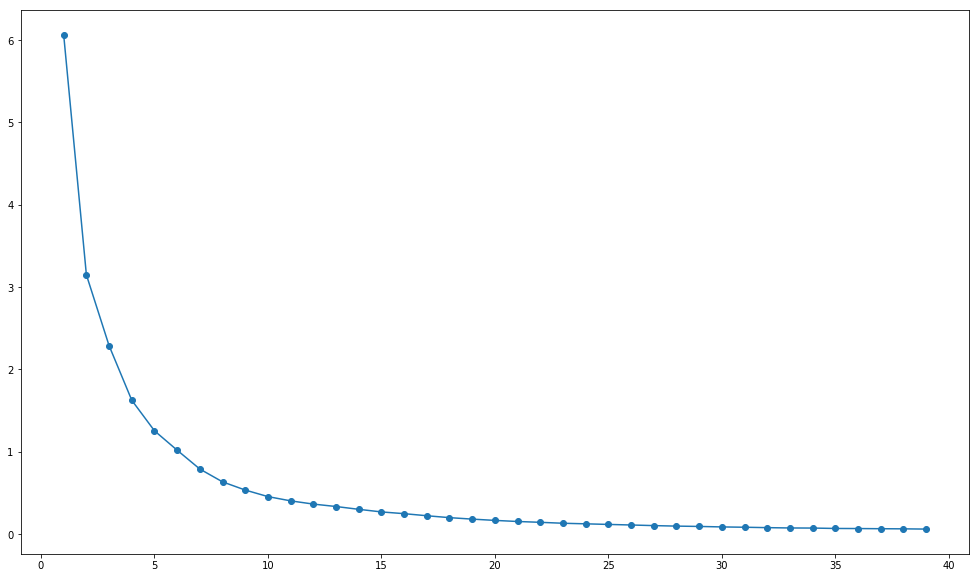

In [8]:
# plotting change of within-cluster distances
clust_count = [x for x in range(1,40)]
all_centroids_new = [-x for x in all_centroids]

plt.figure(figsize=(17,10))
plt.plot(clust_count, all_centroids_new, marker='o');


Looking at the above plot, it is very difficult to identify the 'elbow' of the graph. To support the identification of a good amount of clusters, I will use the silhouette score.

In [10]:
# code partially taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
# calculating the silhouette score for up to 40 clusters
total_scores = []

for i in range(2,40):
    clusterer = KMeans(n_clusters=i, random_state=42)
    preds = clusterer.fit_predict(bike_station_df_drop)
    centers = clusterer.cluster_centers_

    score = silhouette_score(bike_station_df_drop, preds, metric='euclidean')
    total_scores.append(score)
    print ("For n_clusters = {}, the silhouette score is {})".format(i, score))
    

For n_clusters = 2, the silhouette score is 0.6005110877253983)
For n_clusters = 3, the silhouette score is 0.5786439989005002)
For n_clusters = 4, the silhouette score is 0.40334655340608633)
For n_clusters = 5, the silhouette score is 0.41117797107922893)
For n_clusters = 6, the silhouette score is 0.41835352389379443)
For n_clusters = 7, the silhouette score is 0.4070196202053189)
For n_clusters = 8, the silhouette score is 0.4353822385774991)
For n_clusters = 9, the silhouette score is 0.4495844781190487)
For n_clusters = 10, the silhouette score is 0.4544670158528923)
For n_clusters = 11, the silhouette score is 0.4586608042175479)
For n_clusters = 12, the silhouette score is 0.45067735389947144)
For n_clusters = 13, the silhouette score is 0.45886598261021216)
For n_clusters = 14, the silhouette score is 0.45837025670164944)
For n_clusters = 15, the silhouette score is 0.4514252926974311)
For n_clusters = 16, the silhouette score is 0.45217929413971336)
For n_clusters = 17, the s

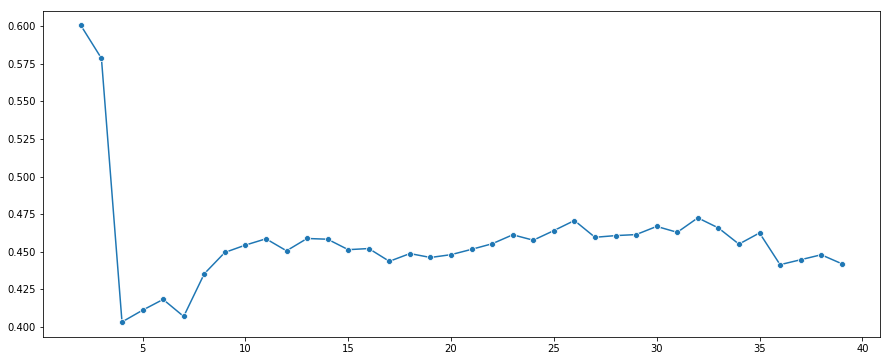

In [11]:
# remove first iteration of clust_count
clust_count.pop(0)

# plotting the silhouette scores
plt.figure(figsize=[15,6])
sb.lineplot(clust_count, total_scores, marker='o');


Based on the above plot, I will use 26 clusters. The higher the silhouette score, the better the clusters are separated from each other. 32 clusters are too many and 2 or 3 clusters are too little. I will plot the clusters with their centroids below to do a visual check on whether the clustering makes sense.

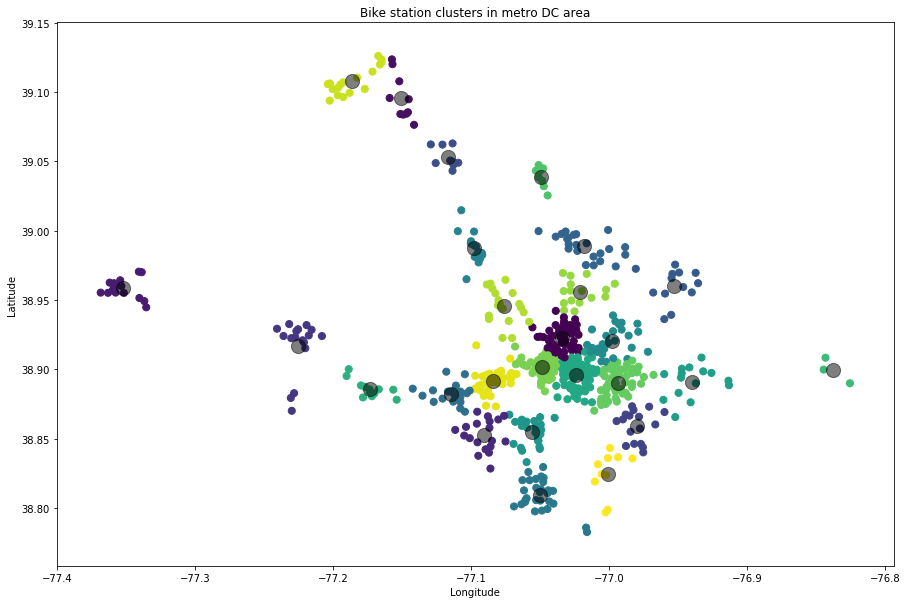

In [14]:
# code is partially taken from https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# plotting kmeans to 
kmeans = KMeans(n_clusters=26)
kmeans.fit(bike_station_df_drop)
y_kmeans = kmeans.predict(bike_station_df_drop)

plt.figure(figsize=(15,10))
plt.scatter(bike_station_df_drop['LONGITUDE'], 
            bike_station_df_drop['LATITUDE'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5);
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bike station clusters in metro DC area');


The above plot confirms that 26 is a sensible number of clusters. The 'far out' bike stations are reasonably clustered and the D.C. inner city area has 5 dense clusters.

In [ ]:
# assigning the cluster number to each station
bike_station_df['cluster'] = y_kmeans


In [ ]:
# drop all irrelevant columns
bike_station_final = bike_station_df.drop(['OBJECTID', 'ID', 'INSTALLED', 'LOCKED', 'INSTALL_DATE',
                                             'REMOVAL_DATE', 'TEMPORARY_INSTALL', 'NUMBER_OF_BIKES',
                                             'NUMBER_OF_EMPTY_DOCKS', 'X', 'Y', 'SE_ANNO_CAD_DATA',
                                             'OWNER', 'LATITUDE', 'LONGITUDE'], axis=1)

bike_station_final.rename(columns={'ADDRESS': 'station_address', 'TERMINAL_NUMBER': 'Start station number'}, inplace=True)
bike_station_final.head()


## Bike sharing demand dataset

In [ ]:
# merge the bike sharing demand csv files into one dataframe for Washington, D.C.
path = r'C:\Users\julia\Documents\Studium\Master\2. Semester\Master-Seminar Applied Econometrics - Data Science Basics\bike-sharing\datasets\bike-sharing'
all_files = glob.glob(path + "/*.csv")

df_list = []

for file in all_files:
    df_comp = pd.read_csv(file)
    df_list.append(df_comp)
    
df_bike = pd.concat(df_list, axis=0, ignore_index=True)


In [ ]:
# get overview of dataframe
print(df_bike.shape)
df_bike.head()


In [ ]:
# drop columns that are irrelevant
df_bike_drop = df_bike.drop(['Duration', 'Start station', 'End station number', 
                             'End station', 'Bike number', 'End date'], axis=1)

# create new column that only contains the date
df_bike_drop['date'] = df_bike_drop['Start date'].apply(lambda x: x[:10])

# drop the Start date column
df_bike_drop.drop(['Start date'], axis=1, inplace=True)




In [ ]:
# merge df_bike_drop and bike_station_final on the start station column
df_demand_station = df_bike_drop.merge(bike_station_final, how='left', on='Start station number')
df_demand_station.head()


In [ ]:
df_demand_station

In [ ]:
# create two new columns for number of casual and registered customers per day
df_demand_station['casual'] = df_demand_station['Member type'].apply(lambda x: 1 if x == 'Casual' else 0)
df_demand_station['registered'] = df_demand_station['Member type'].apply(lambda x: 1 if x == 'Member' else 0)

# create new dataframe with date, casual, registered and total customers
cust_list = ['casual', 'registered']
df_bike_list = []

for cust in cust_list:
    series_bike_users = df_demand_station.groupby(['date', 'cluster'])[cust].sum()
    df_bike_users = series_bike_users.to_frame()
    df_bike_list.append(df_bike_users)
    
# concat both dataframes saved in list and add new column containing total number of customers
df_bike_cust = pd.concat(df_bike_list, axis=1)
df_bike_cust.reset_index(inplace=True)
df_bike_cust['total_cust'] = df_bike_cust['casual'] + df_bike_cust['registered']
df_bike_cust


## Holiday dataset

In [ ]:
# manual creation of dataframe containing information on holidays in Washington, D.C.
# source for this is https://dchr.dc.gov/page/holiday-schedules-2018, https://dchr.dc.gov/page/holiday-schedules-2016-and-2017
# https://dchr.dc.gov/page/holiday-schedules-2014-and-2015, https://dchr.dc.gov/page/holiday-schedules-2012-and-2013
# https://dchr.dc.gov/page/holiday-schedules-2010-and-2011

df_holiday = pd.DataFrame(columns=['date', 'holiday'])

dates = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-04-16',
         '2018-05-28', '2018-07-04', '2018-09-03', '2018-10-08',
         '2018-11-12', '2018-11-22', '2018-12-25', '2017-01-02',
         '2017-01-16', '2017-01-20', '2017-02-20', '2017-04-17',
         '2017-05-29', '2017-07-04', '2017-09-04', '2017-10-09',
         '2017-11-10', '2017-11-23', '2017-12-25', '2016-01-01',
         '2016-01-18', '2016-02-15', '2016-04-15', '2016-05-30',
         '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11',
         '2016-11-24', '2016-12-26', '2015-01-01', '2015-01-19',
         '2015-02-16', '2015-04-16', '2015-05-25', '2015-07-03',
         '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26',
         '2015-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
         '2014-04-16', '2014-05-26', '2014-07-04', '2014-09-01', 
         '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25',
         '2013-01-01', '2013-01-21', '2013-01-20', '2013-02-18', 
         '2013-04-16', '2013-05-27', '2013-07-04', '2013-09-02',
         '2013-10-14', '2013-11-11', '2013-11-28', '2013-12-25',
         '2012-01-02', '2012-01-16', '2012-02-20', '2012-04-16',
         '2012-05-28', '2012-07-04', '2012-09-03', '2012-10-08',
         '2012-11-12', '2012-11-22', '2012-12-25', '2011-01-17',
         '2011-02-21', '2011-04-15', '2011-05-30', '2011-07-04',
         '2011-09-05', '2011-10-10', '2011-11-11', '2011-11-24',
         '2011-12-26']

df_holiday['date'] = dates
df_holiday['holiday'] = 1
df_holiday.head()


## Weather dataset

In [ ]:
# read in the weather data for Washington, D.C.
path = r'C:\Users\julia\Documents\Studium\Master\2. Semester\Master-Seminar Applied Econometrics - Data Science Basics\bike-sharing\datasets\weather-data'
all_files = glob.glob(path + "/*.csv")

df_list_weather = []

for file in all_files:
    df_comp_weather = pd.read_csv(file, low_memory=False)
    df_list_weather.append(df_comp_weather)
    
df_weather = pd.concat(df_list_weather, axis=0, ignore_index=True, sort=False)


In [ ]:
# number of rows and columns in weather dataframe
df_weather.shape


In [ ]:
# get an idea of the datatypes on the weather dataframe
df_weather.dtypes


In [ ]:
df_weather.describe(include='all')

In [ ]:
# show all available weather situation columns and create a list without the attribute columns
weathersit_list = list(df_weather.columns)[12:]
weathersit = [x for x in weathersit_list if len(x) < 5 and 'WT' in x]
weathersit


In [ ]:
# create a new data frame that contains only average temperature, windspeed, precipitation and weathersituation
# per day across all stations in Washington, D.C.
var_list = ['TAVG', 'TMIN', 'TMAX', 'TOBS', 'PRCP', 'AWND', weathersit]
df_avg_list = []

for var in var_list:
    if type(var) != list:
        data_avg_vars = df_weather.groupby('DATE')[var].mean()
        df_avg_vars = data_avg_vars.to_frame()
        df_avg_list.append(df_avg_vars)
    else:
        for sit in weathersit:
            data_wsit = df_weather.groupby('DATE')[sit].max()
            df_wsit = data_wsit.to_frame()
            df_avg_list.append(df_wsit)
            
df_weather_aggr = pd.concat(df_avg_list, axis=1)
df_weather_aggr


In [ ]:
# reset index and change column names
df_weather_aggr.reset_index(inplace=True)

df_weather_aggr = df_weather_aggr.rename(columns={'DATE': 'date', 'TAVG': 'temp_avg', 'TMAX': 'temp_max',
                                                  'TMIN': 'temp_min', 'TOBS': 'temp_observ', 'PRCP': 'precip', 
                                                  'AWND': 'wind','WT01': 'wt_fog', 'WT02': 'wt_heavy_fog', 
                                                  'WT03': 'wt_thunder', 'WT04': 'wt_sleet', 'WT05': 'wt_hail', 
                                                  'WT06': 'wt_glaze', 'WT08':'wt_haze', 'WT09':'wt_drift_snow', 
                                                  'WT11': 'wt_high_wind', 'WT13': 'wt_mist', 'WT14': 'wt_drizzle', 
                                                  'WT15': 'wt_freeze_drizzle', 'WT16': 'wt_rain', 'WT17': 'wt_freeze_rain', 
                                                  'WT18': 'wt_snow', 'WT19': 'wt_unknown', 'WT21': 'wt_ground_fog', 
                                                  'WT22': 'wt_ice_fog'})
df_weather_aggr.head()


In [ ]:
# check the shape of the above dataframe
df_weather_aggr.shape


## Combination of all three separate datasets

In [ ]:
# merge the holiday dataframe with the bike customer dataframe
df_bike_holiday = df_bike_cust.merge(df_holiday, how='left', on='date')

# check the shape of the new dataframe
df_bike_holiday.shape


In [ ]:
# merge the df_bike_holiday dataframe with the weather dataframe
df_bike_holiday_weather = df_weather_aggr.merge(df_bike_holiday, how='left', on='date')

# check the shape of the new dataframe
df_bike_holiday_weather.shape


In [ ]:
# look at the new dataframe
df_bike_holiday_weather.head()


In [ ]:
# write the final dataframe to a csv file
df_bike_holiday_weather.to_csv('bike_sharing_dataset.csv', sep=',', index=False)

